### Getting started with feature importance and fairness using ML & SHAP


* We'll look at feature importance according to ML models. 
* We can use multiple methods - e.g. permutation importance, shapley, and the  difference in feature importance from different models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import shap
import gc

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
warnings.simplefilter(action='ignore', category=FutureWarning)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/compass/cox-violent-parsed.csv
/kaggle/input/compass/cox-violent-parsed_filt.csv
/kaggle/input/compass/compas-scores-raw.csv
/kaggle/input/compass/propublicaCompassRecividism_data_fairml.csv/._propublica_data_for_fairml.csv
/kaggle/input/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv


In [2]:
# import pandas as pd
compas_scores_raw = pd.read_csv("../input/compass/compas-scores-raw.csv")
cox_violent_parsed = pd.read_csv("../input/compass/cox-violent-parsed.csv")
cox_violent_parsed_filt = pd.read_csv("../input/compass/cox-violent-parsed_filt.csv")


In [3]:
print (type(compas_scores_raw))
compas_scores_raw.head()

<class 'pandas.core.frame.DataFrame'>


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [4]:
TARGET_COL = "Two_yr_Recidivism"

## We'll start with the naive fairML subset of the data. Very simple
* **Target column**: `Two_yr_Recidivism` = recividism (any) within 2 years
* Note that we have fewer variables and features here.


In [5]:
df = pd.read_csv("../input/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

print(df.shape)
display(df.columns)
df.head()

(6172, 12)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [6]:
data = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

In [7]:
# Here is a way to select these columns using the column names
    
#feature_columns = ['Number_of_Priors', 'score_factor','Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American','Asian', 'Hispanic', 'Native_American', 'Other', 'Female',       'Misdemeanor']
feature_columns = ['Number_of_Priors', 'score_factor','Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Misdemeanor']

data = df[feature_columns].values
y = df['Two_yr_Recidivism'].values

### Gradient Boosting Classsifer
The original code used LightGBC to classify the data.  
https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab

We can substitute other learning methods in place of this. I added KNN, SVM and Decision Trees below.


In [8]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

In [9]:
print ("test")
print (type(train_x))
print ("Shape of training input : ",train_x.shape)
print ("Shape of training output : ",train_y.shape)

test
<class 'numpy.ndarray'>
Shape of training input :  (4629, 5)
Shape of training output :  (4629,)


In [10]:
from sklearn.neighbors import KNeighborsClassifier
# Set up the K-Nearest neighbor model using the k nearest neighbors. Change the value of n_neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
# Train the model on the iris data
knn_model.fit(train_x, train_y)
score = knn_model.score(valid_x, valid_y)
print ("The score for this model is ", score)

The score for this model is  0.6681788723266364


# Section 2: Support Vector Machine (SVM)

SVM is another algorithm for classifying data. It tries to divide the data up using lines, sometimes straight linear lines and sometimes curved lines.

SVM tries to find the best lines - actually, a plane in multiple dimensions - to divide the data up into the known categories.
## Linear SVM Classification




In [11]:
from sklearn.svm import SVC

# Set up SVM model with a given kernel and c parameter
svm_model = SVC(C=1.0, kernel='linear')         # linear SVM
#svm_model = SVC(C=10.0, kernel='rbf')           # non-linear SVM

# Train the model on the iris data
svm_model.fit(train_x, train_y)
score = svm_model.score(valid_x, valid_y)
print ("The score for this model is ", score)

The score for this model is  0.659753726506805


In [12]:
# This is the actual score used in the origianl notebook
y_pred = svm_model.predict(valid_x)
score = roc_auc_score(valid_y, y_pred)
print("Overall AUC on validation: {:.3f}" .format(score))

Overall AUC on validation: 0.656


# Section 3: Decision Trees 
This classification method tries to break the classification task into a series of decisions structured as a tree.
> Like SVMs, Decision Trees are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets.
- From *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*, 2nd Edition by Aurélien Géron, ISBN-13: 978-1492032649

In [13]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier()

# Train the model on the iris data
DT_model.fit(train_x, train_y)
score = DT_model.score(valid_x, valid_y)
print ("The score for this model is ", score)

The score for this model is  0.6688269604666235


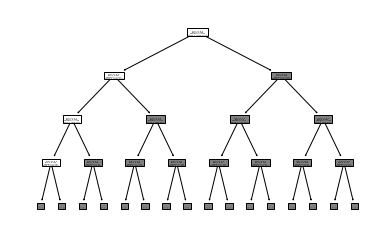

In [14]:
from sklearn import tree

tree.plot_tree(DT_model, max_depth=3);